# Skeleton Notebook Deep Q-Learning Project (MHBF)

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import required packages
import gym
import gym_grid

import matplotlib.pyplot as plt

import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython import display
from collections import namedtuple, deque
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

# 0. Environment Implementation

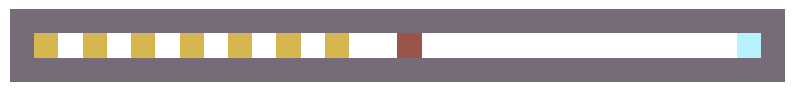

In [4]:
# Visualize the environment
plt.figure(figsize=(10, 10))
# T-Maze Environment
env = gym.make("LinearTrack-v0")
#env = gym.make("DeadlyGrid-v0")
_, obs_to_render = env.reset_with_render()
env.reset()
env.render(obs_to_render)

In [5]:
print('State space: ', env.observation_space)
print('State shape: ', env.observation_space.shape)
print('Action space: ', env.action_space)
print('Number of actions: ', env.action_space.n)

State space:  Box(0, 1, (3, 32, 4), uint8)
State shape:  (3, 32, 4)
Action space:  Discrete(3)
Number of actions:  3


# 1. Definition of model and params

In [10]:
# Discount factor
GAMMA = 0.99
# Learning rate
LEARNING_RATE = 0.001
# Capacity of the replay buffer
BUFFER_SIZE = 1000
# Update target net every ... episodes
UPDATE_EVERY= 500
# Batch size
BATCH_SIZE = 128
# Eval Episode
EVAL_EPISODE = 500
# Number of eval
N_EVAL = 50
# Hidden Units
HIDDEN_UNITS = 128
# Hidden layers
HIDDEN_LAYERS = 1
# Number of training episodes
N_EPISODES = 30000
# Initial value of epsilon
EPSILON_START = 1.0
# End value of epsilon
EPSILON_END = 0.01
# Epsilon decay
EPSILON_DECAY = (EPSILON_START - EPSILON_END) / N_EPISODES

In [12]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_units, hidden_layers):
        super(DQN, self).__init__()
        
        self.action_space_size = output_dim
        self.hidden_layers = hidden_layers
        self.layer_in = nn.Linear(input_dim, hidden_units)
        self.hidden_layer= nn.Linear(hidden_units, hidden_units)
        self.layer_out = nn.Linear(hidden_units, output_dim)
    
    def forward(self, x):
        x = F.relu(self.layer_in(x))
        for i in range(self.hidden_layers):
            x = F.relu(self.hidden_layer(x))
        x = self.layer_out(x)
        return x

    def action(self, state, epsilon):
        if random.random() > epsilon:
            state   = torch.tensor(state, dtype=torch.float32).flatten()
            q_value = self.forward(state)
            action  = int(torch.argmax(q_value, dim=-1))
        else:
            action = random.randrange(self.action_space_size)
        return action 

In [14]:
def test_agent(model, gamma):
    done = False
    episode_return = 0
    i = 0
    state = env.reset()
    with torch.no_grad():
        while not done:
            action = model.action(state, 0.01)
            state, reward, done, info = env.step(action)
            episode_return += gamma**i * reward
            i += 1
    return episode_return

# 2. Baseline

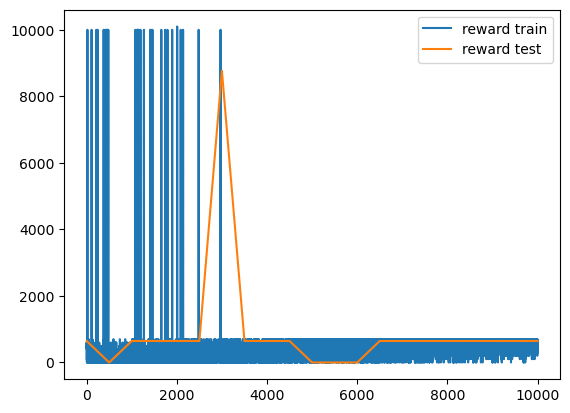

 34%|████████████▋                        | 10256/30000 [14:10<21:31, 15.29it/s]

In [ ]:
model_baseline = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                     env.action_space.n,
                     HIDDEN_UNITS, 
                     HIDDEN_LAYERS)
optimizer = optim.Adam(params=model_baseline.parameters(), lr=LEARNING_RATE)

step = 0
test_rewards = []
test_epochs = []
train_rewards = []
eps = EPSILON_START
for step in tqdm(range(N_EPISODES)):
    done = False
    state = env.reset()
    r_train = 0
    while not done:
        action = model_baseline.action(state, eps)
        next_state, reward, done, info = env.step(action)
        r_train += reward
        
        next_state_values = model_baseline(torch.tensor(next_state, dtype=torch.float32).flatten()).max().detach()
        state_action_values = model_baseline(torch.tensor(state, dtype=torch.float32).flatten())[action]
        
        expected_q_value = reward + GAMMA * next_state_values * (1 - done)
        loss = nn.MSELoss()(state_action_values, expected_q_value)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        state = next_state
    train_rewards.append(r_train)   
    
    if step%EVAL_EPISODE == 0:
        r_test = []
        for j in range(N_EVAL):
            returns.append = test_agent(model_baseline, GAMMA)
            r_test.append(r)
            
        test_epochs.append(step)
        test_rewards.append(np.mean(r_test))
        
        display.clear_output(True)
        plt.plot(train_rewards, label = "reward train")
        plt.plot(test_epochs,test_rewards, label = "reward test")
        plt.legend()
        plt.show()
        
    eps -= EPSILON_DECAY
    step += 1


In [ ]:
state, obs_to_render = env.reset_with_render()
env.render(obs_to_render)
done = False
tot_rew_test = 0
with torch.no_grad():
        while not done:
            action = model_baseline.action(state, 0)
            state, rew , done, _, obs_to_render = env.step_with_render(action)
            tot_rew_test += rew
            env.render(obs_to_render)
            display.display(plt.gcf())
            display.clear_output(wait=True)
print(tot_rew_test)

# 3. Replay Buffer

In [ ]:
class ReplayBuffer:
    def __init__(self, data_names, buffer_size, batch_size):
        self.data_keys = data_names
        self.data_dict = {}
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.reset()
    
    def reset(self):
        for name in self.data_keys:
            self.data_dict[name] = deque(maxlen=self.buffer_size)

    def push(self, data):
        """Add a transition to the buffer."""
        for key in self.data_keys:
            self.data_dict[key].append(data[key])

    def sample(self):
        """Sample a batch of transitions."""
        indices = random.sample(range(len(self)), self.batch_size)
        batch = [{key: self.data_dict[key][i] for key in self.data_keys} for i in indices]
        return batch

    def __len__(self):
        return len(next(iter(self.data_dict.values())))

In [ ]:
model_replay_buffer = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                          env.action_space.n,
                          HIDDEN_UNITS, 
                          HIDDEN_LAYERS)

replay_buffer = ReplayBuffer(['state', 'action', 'reward', 'next_state', 'done'], 
                             BUFFER_SIZE, BATCH_SIZE)

optimizer = optim.Adam(params=model_replay_buffer.parameters(), lr=LEARNING_RATE)

step = 0
test_rewards = []
test_epochs = []
train_rewards = []
eps = EPSILON_START
for step in tqdm(range(N_EPISODES)):
    done = False
    state = env.reset()
    r_train = 0
    while not done:
        action = model_replay_buffer.action(state, eps)
        next_state, reward, done, info = env.step(action)
        replay_buffer.push({'state':state, 'action':action, 'reward':reward, 
                            'next_state':next_state, 'done':done})
        r_train += reward
        
    train_rewards.append(r_train)
    
    if len(replay_buffer) > replay_buffer.batch_size:
        batch = replay_buffer.sample()
        for b in batch:            
            next_state_values = model_replay_buffer(torch.tensor(b['next_state'], dtype=torch.float32).flatten()).max().detach()
            state_action_values = model_replay_buffer(torch.tensor(b['state'], dtype=torch.float32).flatten())[b['action']]
        
            expected_q_value = b['reward'] + GAMMA * next_state_values * (1 - b['done'])
            loss = nn.MSELoss()(state_action_values, expected_q_value)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    if step%EVAL_EPISODE == 0:        
        r_test = []
        for j in range(10):
            r = test_agent(model_replay_buffer, GAMMA)
            r_test.append(r)
        test_epochs.append(step)
        test_rewards.append(np.mean(r_test))
        
        display.clear_output(True)
        plt.plot(train_rewards, label = "reward train")
        plt.plot(test_epochs,test_rewards, label = "reward test")
        plt.legend()
        plt.show()
        
    eps -= EPSILON_DECAY
    step += 1

In [ ]:
state, obs_to_render = env.reset_with_render()
env.render(obs_to_render)
done = False
tot_rew_test = 0
with torch.no_grad():
        while not done:
            action = model_replay_buffer.action(state, 0)
            state, rew , done, _, obs_to_render = env.step_with_render(action)
            tot_rew_test += rew
            env.render(obs_to_render)
            display.display(plt.gcf())
            display.clear_output(wait=True)
print(tot_rew_test)

# 4. Target Network

In [ ]:
model_tn = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                          env.action_space.n,
                          HIDDEN_UNITS, 
                          HIDDEN_LAYERS)

model_tn_target = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                          env.action_space.n,
                          HIDDEN_UNITS, 
                          HIDDEN_LAYERS)
model_tn_target.load_state_dict(model_tn.state_dict())

replay_buffer = ReplayBuffer(['state', 'action', 'reward', 'next_state', 'done'], 
                             BUFFER_SIZE, BATCH_SIZE)

optimizer = optim.Adam(params=model_tn.parameters(), lr=LEARNING_RATE)

step = 0
test_rewards = []
test_epochs = []
train_rewards = []
eps = EPSILON_START
for step in tqdm(range(N_EPISODES)):
    done = False
    state = env.reset()
    r_train = 0
    while not done:
        action = model_tn.action(state, eps)
        next_state, reward, done, info = env.step(action)
        replay_buffer.push({'state':state, 'action':action, 'reward':reward, 
                            'next_state':next_state, 'done':done})
        r_train += reward
        
    train_rewards.append(r_train)
    
    if len(replay_buffer) > replay_buffer.batch_size:
        batch = replay_buffer.sample()
        for b in batch:      
            
            next_state_values = model_tn_target(torch.tensor(b['next_state'], dtype=torch.float32).flatten()).max().detach()
            state_action_values = model_tn(torch.tensor(b['state'], dtype=torch.float32).flatten())[b['action']]
        
            expected_q_value = b['reward'] + GAMMA * next_state_values * (1 - b['done'])
            
            loss = nn.MSELoss()(state_action_values, expected_q_value)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
     if step % UPDATE_EVERY == 0:
        model_tn_target.load_state_dict(model_tn.state_dict())
    
    if step%EVAL_EPISODE == 0:        
        r_test = []
        for j in range(10):
            r = test_agent(model_tn, GAMMA)
            r_test.append(r)
        test_epochs.append(step)
        test_rewards.append(np.mean(r_test))
        
        display.clear_output(True)
        plt.plot(train_rewards, label = "reward train")
        plt.plot(test_epochs,test_rewards, label = "reward test")
        plt.legend()
        plt.show()
        
    eps -= EPSILON_DECAY
    step += 1

# 5. Loss Function Comparaison

In [ ]:
model_tn_2 = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                          env.action_space.n,
                          HIDDEN_UNITS, 
                          HIDDEN_LAYERS)

model_tn_target_2 = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                          env.action_space.n,
                          HIDDEN_UNITS, 
                          HIDDEN_LAYERS)
model_tn_target.load_state_dict(model_tn.state_dict())

replay_buffer = ReplayBuffer(['state', 'action', 'reward', 'next_state', 'done'], 
                             BUFFER_SIZE, BATCH_SIZE)

optimizer = optim.Adam(params=model_tn_2.parameters(), lr=LEARNING_RATE)

step = 0
test_rewards = []
test_epochs = []
train_rewards = []
eps = EPSILON_START
for step in tqdm(range(N_EPISODES)):
    done = False
    state = env.reset()
    r_train = 0
    while not done:
        action = model_tn_2.action(state, eps)
        next_state, reward, done, info = env.step(action)
        replay_buffer.push({'state':state, 'action':action, 'reward':reward, 
                            'next_state':next_state, 'done':done})
        r_train += reward
        
    train_rewards.append(r_train)
    
    if len(replay_buffer) > replay_buffer.batch_size:
        batch = replay_buffer.sample()
        for b in batch:      
            
            next_state_values = model_tn_target_2(torch.tensor(b['next_state'], dtype=torch.float32).flatten()).max().detach()
            state_action_values = model_tn_2(torch.tensor(b['state'], dtype=torch.float32).flatten())[b['action']]
        
            expected_q_value = b['reward'] + GAMMA * next_state_values * (1 - b['done'])
            
            loss = nn.SmoothL1Loss()(state_action_values, expected_q_value)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
     if step % UPDATE_EVERY == 0:
        model_tn_target_2.load_state_dict(model_tn_2.state_dict())
    
    if step%EVAL_EPISODE == 0:        
        r_test = []
        for j in range(10):
            r = test_agent(model_tn_2, GAMMA)
            r_test.append(r)
        test_epochs.append(step)
        test_rewards.append(np.mean(r_test))
        
        display.clear_output(True)
        plt.plot(train_rewards, label = "reward train")
        plt.plot(test_epochs,test_rewards, label = "reward test")
        plt.legend()
        plt.show()
        
    eps -= EPSILON_DECAY
    step += 1

# 6. Behavioural Analysis

# 7. Prioritized Experience Replay 